# A gentle introduction to Stable Diffusion: Part 3 - The Variational Auto Encoders for Image Compression

Hello and welcome (back) to this explainer for Stable Diffusion - specifically targeting a non-technical audience. This will be a quick rundown of how *Latent Diffusion Models* (LDMs) work, specifically focusing on Stable Diffusion v1.4, as it is probably the most intuitive to explain.

This explainer will be split into multiple parts - first, we will give a high level overview of the model cascade itself, then we'll go into each component of the cascade, and finally, we'll put the model cascade together at the end!

This is the third section out of five: a look at the Variational Auto Encoder. The other sections are accessible [here]( https://research.qut.edu.au/genailab/projects/unboxing-genai/)

1. [Introduction to Latent Diffusion Models](https://colab.research.google.com/github/QUT-GenAI-Lab/genai-explained/blob/main/notebooks/1401%20Introduction%20to%20Latent%20Diffusion%20Models.ipynb)
2. [CLIP Text embedder](https://colab.research.google.com/github/QUT-GenAI-Lab/genai-explained/blob/main/notebooks/1402%20The%20CLiP%20Text%20Embedding%20Model.ipynb)
3. **Variational Auto Encoders for image compression**
4. [UNet denoiser](https://colab.research.google.com/github/QUT-GenAI-Lab/genai-explained/blob/main/notebooks/1404%20Convolutional%20UNet%20De-Noiser.ipynb)
5. [Conclusion - putting it all together](https://colab.research.google.com/github/QUT-GenAI-Lab/genai-explained/blob/main/notebooks/1405%20The%20Full%20Model%20Cascade.ipynb)


## The Stable Diffusion Variational Auto Encoder

Let's now take a look at the image compression model in Stable Diffusion. If you recall, this module is responsible for taking images at a reasonable resolution and squashing them into a much smaller amount of data. The reason Stable Diffusion does this is so that the rest of the model can operate much more efficiently, rather than dealing with the larger quantity of data needed for working with raw image pixels. Specifically, the model that Stable Diffusion uses is called a Variational AutoEncoder.

### What is a Variational AutoEncoder?

To begin, let's develop a high level intuition about the Variational AutoEncoder itself. To do this let's ignore the "Variational" part of the name, and focus on the AutoEncoder first.

As the name suggests, an AutoEncoder is a "self" encoder, essentially meaning that its primary goal is to encode its own input data into a descriptive latent space. Typically as well, this latent space is significantly "smaller", in the sense that it takes up significantly less data. These are also often trained with a decoder attached (or a model that reconstructs the latent space back to its original input as best as possible), and its success is measured through "reconstruction loss", or more intuitively, how similar the final decoded output is to the input.

![Simplified diagram of an AutoEncoder (not variational!](./assets/1403-AE_diagram.png)

*diagram of AutoEncoder architecture*

A Variational AutoEncoder functions quite similarly, but with a few key changes that deal with potential drawbacks of an AutoEncoder. One big drawback of AutoEncoders is that, given how these models are trained, there's nothing stopping the model from encoding "discrete" values to the latent space, with no meaningful interpolation between points/values. Using the same map analogy as introduced in [part 1](https://colab.research.google.com/github/QUT-GenAI-Lab/genai-explained/blob/main/notebooks/1401%20Introduction%20to%20Latent%20Diffusion%20Models.ipynb), it would be like if you could only draw a road map with straight lines, 90 degree corners, and 4 way intersections. Anything outside of that, like T-sections, roundabouts, over/underpasses, or literally any corner that isn't 90 degrees, would not be drawn accurately.

A VAE, first proposed by [Kingma and Welling in 2013](https://arxiv.org/pdf/1312.6114), fixes this by training the latent space not into discrete points, but probability distributions. Once the VAE is well trained, this allows the latent space to be continuous, and for data between "discrete" points in the latent space to be interpolated. Going back again to the map analogy, you would essentially be able to draw a map with any road feature that you could "interpolate" (or estimate from surrounding values) between any of the previously mentioned features, giving you a much richer toolkit through which you could draw your map!

There are a lot of other features and advantages of VAEs over AEs that aren't covered in this very quick summary, but if you would like to learn more, [this is a great place to start.](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)

 > A tangential interesting note: AutoEncoders are used for many other tasks outside of data compression/dimensionality reduction as well. Canonical examples would be anomaly detection, noise reduction, or as a non-linear substitute for Principal Component Analysis. More recently, and quite interestingly, various types of AutoEncoders have been used as a tool for explainability and/or inference control in deep learning models as well. Essentially, by forcing the encoded space to be a high-dimensional vector (rather than a matrix or tensor), researchers have been able to isolate low-dimensional representations of conceptual features being generated in the latent spaces of models (sometimes even single-dimensional!) What this has meant is that incredibly complicated, non-linear latent spaces within models could be by simple, somewhat linearly interpretable sliders. Great recent examples of this are the [World Models paper from Google Brain](https://worldmodels.github.io/) and Anthropic's recent research into the [feature space of Claude 3](https://transformer-circuits.pub/2024/scaling-monosemanticity/).

---

#### To begin, let's install and load all necessary python modules for this tutorial:

In [1]:
# First, we need to install the required libraries

!pip install -q --upgrade transformers==4.25.1 diffusers

In [2]:
# Import some libraries and set some configuration values

import os
import torch
import requests

import numpy as np

from PIL import Image
from io import BytesIO
from diffusers import AutoencoderKL
from matplotlib import pyplot as plt
from torchvision import transforms as tfms

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"
    

/mnt/c/Users/hew7/Documents/venvs/RF-demos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



We can load the pre-trained Stable Diffusion VAE model from the HuggingFace model hub.


In [3]:

# Load the autoencoder model which will be used to decode the latents into image space
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Calling .half() halves the resolution of the model's weights. This will reduce the quality of the generated
# images very slightly, but saves 50% of the computational resources required, which is great for an explainer like this
vae = vae.to(torch_device).half()


## A demo of the Stable Diffusion VAE - compressing and decompressing an image

First let's just demonstrate how it works as initially designed - let's compress and then decompress an image.

To start with, let's try this picture of a funny monkey.


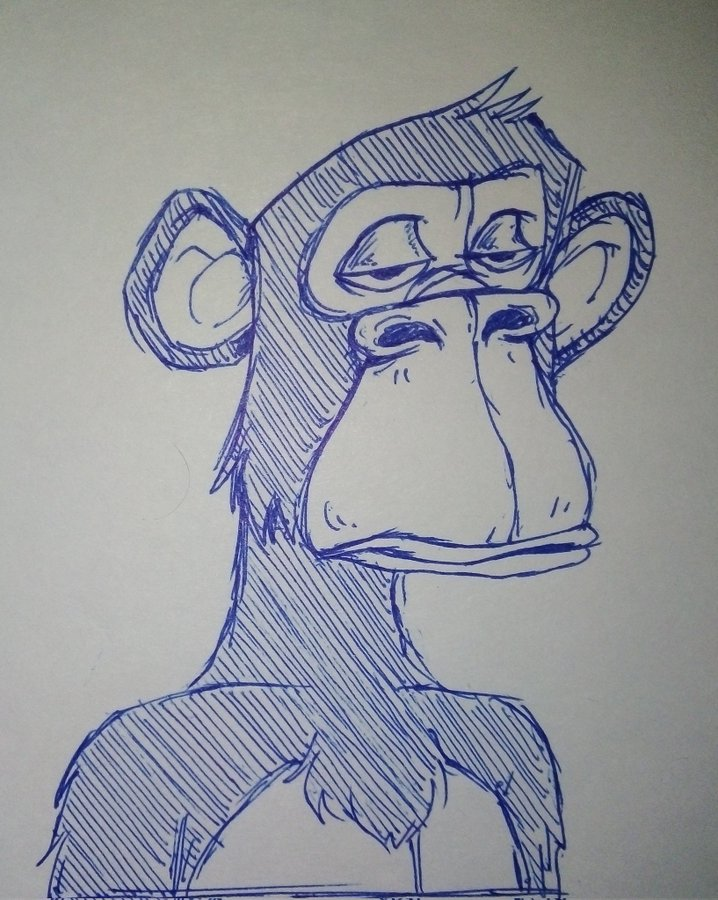

In [61]:

monkey_url = "https://pbs.twimg.com/media/FHCOhT4WQAEA8-6?format=jpg&name=900x900"
monkey_request = requests.get(monkey_url)
monkey_img = Image.open(BytesIO(monkey_request.content))

monkey_img


In [62]:
np.array(monkey_img).shape

(900, 718, 3)


As previously mentioned, the Stable Diffusion VAE can only work with images of size 512x512. So, before we can use this image, we need to adjust it's size.

We can do this in a variety of ways - e.g. stretching the image, or cropping it (or both!) The particular way images are pre-processed before being used for training the VAE is just one of the many, many incremental decisions that go into shaping the 'aesthetic' of the resulting GenAI system.

For the sake of this demo, let's just make sure we keep the top part of this funky monkey.


In [63]:

# Crop out Mr. Musk's face
monkey_img = monkey_img.crop((0, 0, 718, 718))

# Resise to 512 square
monkey_img = monkey_img.resize((512, 512))


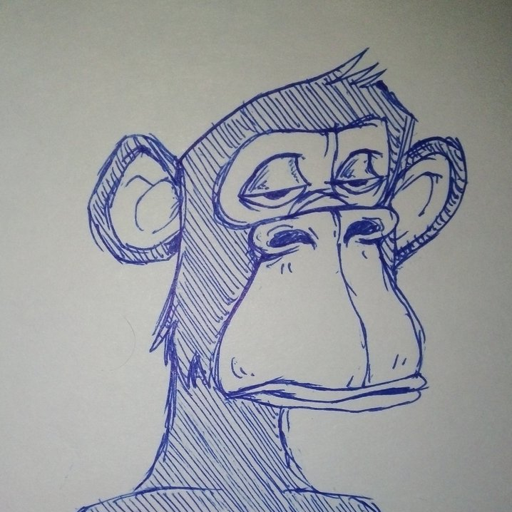

In [64]:

monkey_img



Recall that the Stable Diffusion v1.4 VAE compresses 512x512 images down to a latent space of size 64x64. To illustrate just how little data this is, here we're going to resize this monkey's 512x512 face down to 64x64 pixels using [regular image manipulation methods](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize), and then stretch it back up to 512x512 so we can visualise the result.


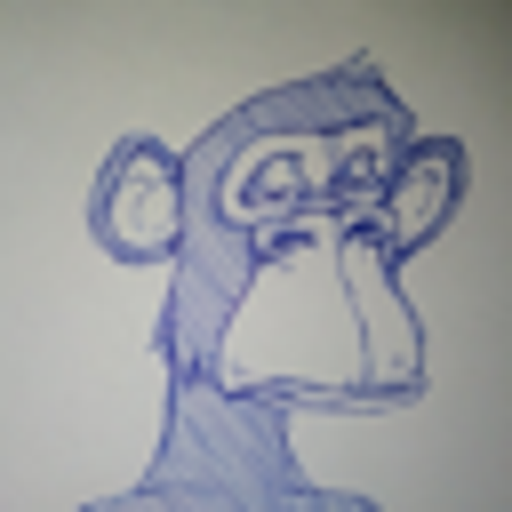

In [65]:

monkey_img_compressed = monkey_img.resize((64, 64))
monkey_img_compressed = monkey_img_compressed.resize((512, 512))

monkey_img_compressed


Wow - looks pretty blurry huh!

Now let's try compressing him through the VAE.

In [66]:

def img2VAETensor(PILImage):
    """Converts an image into a VAE input"""
    PILImage = PILImage.convert('RGB')
    ImgTensor = tfms.ToTensor()(PILImage).unsqueeze(0) * 2.0 - 1.0
    return ImgTensor

def VAE_encode(VAETensor):
    """Encode an image tensor into the latent VAE space"""
    init_encode = vae.encode(VAETensor)
    # This magic number is a scaling factor empirically determined by the original authors of the Stable Diffusion model.
    # Roughly speaking, it compensates for the variation they found in the training image data latent tensors - effectively
    # normalizing the data so that it has slightly better computational performance
    encoded_sample = init_encode.latent_dist.sample() * 0.18215
    return encoded_sample
    
# Convert the image to a tensor form so we can input it to the VAE
monkey_tensor = img2VAETensor(monkey_img).to(torch_device).half()

# Pass the image into the VAE to encode it
monkey_encoded_sample = VAE_encode(monkey_tensor)

# Print out the shape of the encoded latent image representation
monkey_encoded_sample.shape


torch.Size([1, 4, 64, 64])

Looking at the shape of the encoded image sample, we can see that there is essentially 1 image, with 4 channels, each with 64x64 'pixels' of data.

This particular configuration of latent space dimensions is a fairly arbirary choice by the Stable Diffusion v1.4 authors. Conveniently, because we have 4 channels of data, each with 64x64 pixels of data, we can treat each of the channels like a Red, Green, Blue, and Alpha channel from a regular image for the sake of visualising the latent space.

---

### A quick note on latent spaces in general

In this tutorial we cover one way to encode data into a latent space - the Variational AutoEncoder. This is the backbone of the Stable Diffusion models, specifically, but there are many other ways in which data can be encoded, and they don't all look the same! One strategy is via an embedding space - such as the CLiP embedding model we saw in Chapter 2! This is actually the latent space that is used to generate images in [Dall-E 2](https://cdn.openai.com/papers/dall-e-2.pdf). On the other hand, [Microsoft](https://arxiv.org/pdf/2111.14822) use a slightly modified version of a VAE called a VQ-VAE.

We are using Stable Diffusion in particular to explain latent spaces because, given how they have constructed their Variational AutoEncoder, it was likely that their latent space could be visualised somewhat intuitively - which is demonstrably the case, given what we're about to see here. In other latent spaces, like CLiP embeddings, this is not the case.

---

Let's look at the compressed latent 'image' now:


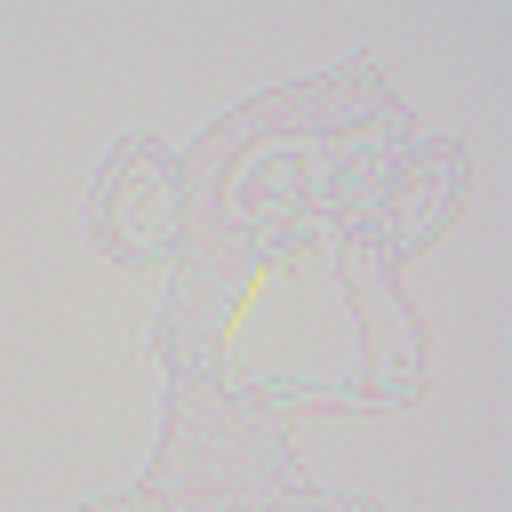

In [51]:

tensor_to_image = tfms.ToPILImage()

# These values are arbitrary, we've just chosen them here to force the monkey's latent values into a 0-1 range which we can visualise
monkey_encoded_sample_normalise_RGBA = (monkey_encoded_sample + 12) / 20

tensor_to_image(monkey_encoded_sample_normalise_RGBA[0]).resize((512, 512))


well look at that - it's all funky looking in the encoded space. But, you can clearly see there's changes in the data that correlate to features in the image itself. There are weird, coloured ridges where the lines in the monkey's face should be! Strange colour shift, but ignore that for now. It's a bit clearer when we look at each individual channel, so let's do that.

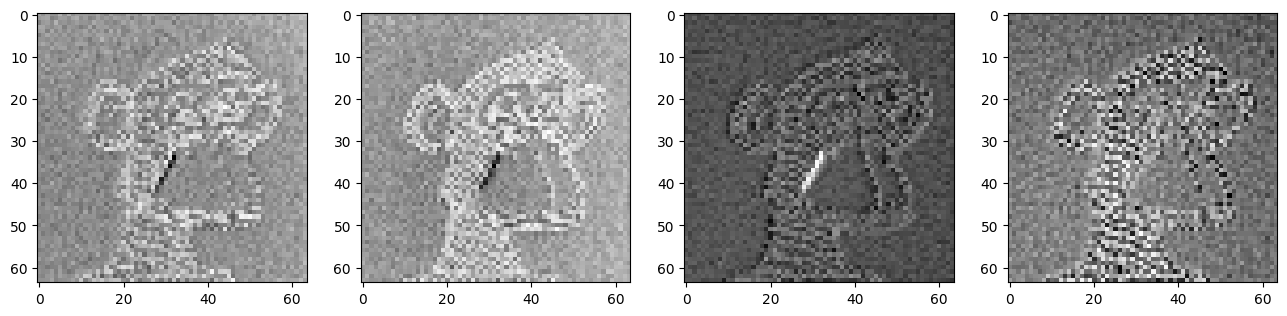

In [52]:

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(monkey_encoded_sample[0][c].detach().cpu(), cmap='Greys')



There seems to be a big hotspot on the right side of his face - interesting to note, but not sure why that is! Perhaps it is to do with the high contrast in the original image near that point?

Let's 'decode' this image now to try and reconstruct the original image from the latent representation.


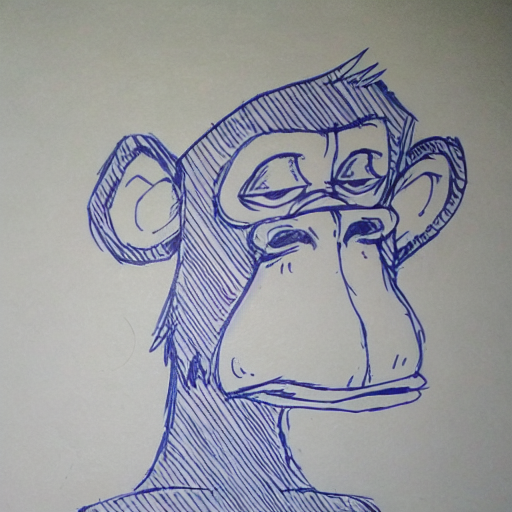

In [53]:

def VAE_decode(VAE_encoded_sample):
    """Decodes a latent image representation"""
    rescaled_sample = ( 1 / 0.18215) * VAE_encoded_sample

    with torch.no_grad():
        decoded_tensor = vae.decode(rescaled_sample).sample

    # Re-scale the decoded image data to the range 0, 1
    decoded_tensor = (decoded_tensor / 2 + 0.5).clamp(0, 1)

    # Shuffle the Red, Green, Blue, Alpha channels around to the correct spots
    decoded_tensor = decoded_tensor.detach().cpu().permute(0, 2, 3, 1).numpy()

    # Scale and convert the data range for visualisation
    decoded_tensor = (decoded_tensor * 255).round().astype("uint8")

    # Convert to an image object
    decoded_tensor_img = Image.fromarray(decoded_tensor[0])

    return decoded_tensor_img

monkey_decoded_img_PIL = VAE_decode(monkey_encoded_sample)
monkey_decoded_img_PIL


Wow - look at that!

This is image looks a *lot* like the original, even though it has been reconstructed from the latent representation, which had 64x less data than the input image.

Let's put all these printouts in a row to compare them. The first image is the original image, the second is the 64x64 image resized with normal image processing, and the third is the VAE encoded -> decoded image.

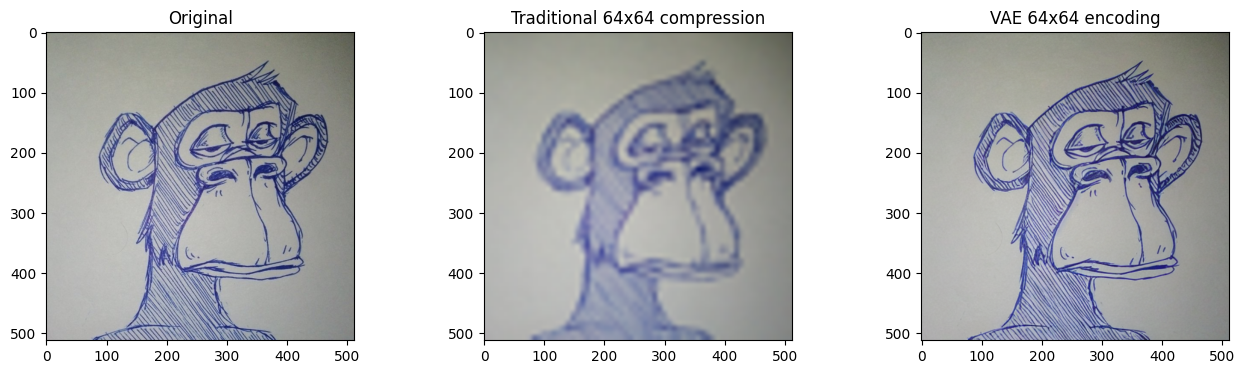

In [55]:
def VAE_comparison(imgs):
    """
    comparison function for orig, compressed, VAE
    must have 3 images specifically in imgs object
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 4)) #figsize=(16, 4)

    ax1.imshow(imgs[0])
    ax1.set_title('Original')
    ax2.imshow(imgs[1])
    ax2.set_title('Traditional 64x64 compression')
    ax3.imshow(imgs[2])
    ax3.set_title('VAE 64x64 encoding')

VAE_comparison([monkey_img, monkey_img_compressed, monkey_decoded_img_PIL])


That's an extremely good result! We can clearly see here that the VAE has done a much better job of compressing the information in the original image compared to a traditional down-res of the image - the VAE output is actually extremely close to the original, despite the fact that we took it down to the same "resolution" as the middle image.

Now why did we go through all that trouble with a VAE, and how does this relate to Stable Diffusion?

Well, the UNet denoising algorithm Stable Diffusion uses to generate images (covered in the next chapter) is *extremely* computationally expensive. As in, if you put a big image file through with the raw pixel data, you might blow up your computer. Using a VAE, we can compress the image to a much smaller amount of data while preserving a *lot* of the detail in the higher resolution image. Further still, given the orthogonal nature of each feature within a VAE's encoded space (the latents, in this case) we can expect the latents/features to be inherently "descriptive" of our image as well - essentially, the values in these latents do a better job of describing the image to a computer than raw RGB values - one number in the latent space might represent how big a person's eyes are, another might represent how blue the sky is, another might represent how many hot dogs are in the photo, et cetera (although that last one's pretty unlikely).

This particular VAE encodes pictures to a latent space that is 64x smaller than the original image. By encoding images into this significantly smaller latent space, this makes the denoising UNet a huge amount easier to train and to run - it will run approximately 64x faster, and the amount of GPU Memory required would be 64x smaller. In real terms, imagine each individual image taking an hour to generate instead of a minute - and imagine how long that would take for the entire 5 billion image LAION-5b dataset! Further still, given the architecture of Stable Diffusion 1.4's UNet, a single image forward pass at 64x64 resolution with the current model uses about 7.4gb of VRAM (6gb for the model, 1.4gb for hidden states). At 512x512, this becomes around 96gb - not even the [newest NVIDA H100 has that amount of VRAM on a single GPU](https://www.nvidia.com/en-us/data-center/h100/)! Decreasing computation requirements was a huge breakthrough that made latent diffusion far more viable at higher resolutions in the first place.

Note though - our monkey image is a particularly good example that we have cherry-picked. Like all models, Stable Diffusion's VAE has limitations in the kinds of features it can/cannot compress well into its latent space - specifically, this will depend on the type and quantity of training data used to make the VAE (among other factors).

To help give a more balanced perspective, in the below cell is a function that outputs the above trifecta of images (left is original, middle is down-scaled, right is VAE-decoded) for any image URL. Note: the function  will automatically crop and resize the input image to be 512x512. If the image is not square, crops will be made from the right/bottom edges (i.e. the top left corner of the image will be retained).

Play around with it and see what results you get! Specifically, try and focus on what details might be inserted into the VAE decoded image, and what details might get lost.

Here are some suggestions to the types of images you could try:

 - Screenshots of fine text
 - Photos of faces
 - Landscape photos
 - Space photos


In [ ]:

def get_image(URL):
    """Gets an image from a URL"""
    ImgURL = requests.get(URL)
    Img = Image.open(BytesIO(ImgURL.content))
    
    lrdiff=Img.size[0]-min(Img.size)
    tbdiff=Img.size[1]-min(Img.size)
    Img = Img.crop((0,0,Img.size[0]-lrdiff, Img.size[1]-tbdiff))
    Img = Img.resize((512,512))
    return Img

def downres(Img):
    """Scale an image down"""
    Img=Img.resize((64,64))
    Img=Img.resize((512,512))
    return Img

def VAE_demo(URL):
    """Do the VAE computation and render the 3 demo images side by side"""
    orig_img=get_image(URL)
    downres_img=downres(orig_img)

    tensor_Img=img2VAETensor(orig_img).to(torch_device).half()
    encodedSample=VAE_encode(tensor_Img)
    decoded_img=VAE_decode(encodedSample)
    return VAE_comparison([orig_img, downres_img, decoded_img])


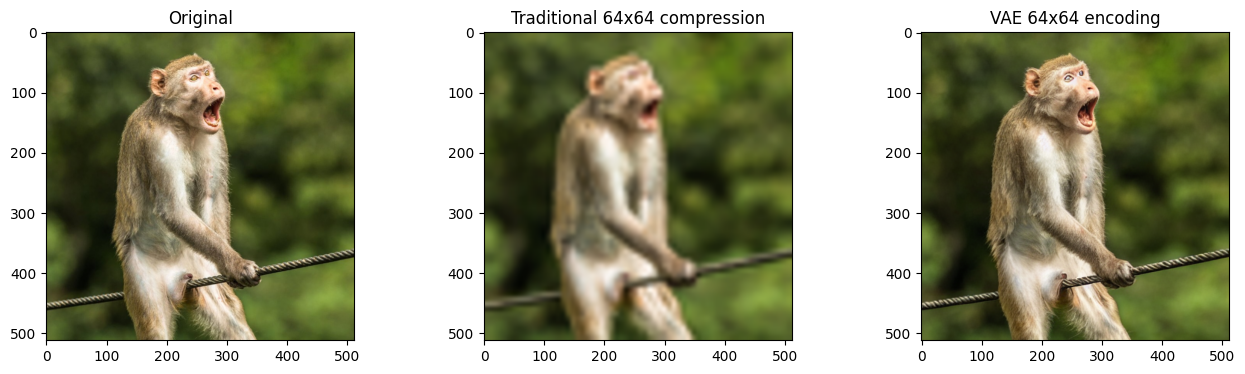

In [68]:

# Have a play here!
# Change the below URL to whatever you want
VAE_demo('https://live-production.wcms.abc-cdn.net.au/20bef573e36cc4d1305bfc14a937291d?impolicy=wcms_crop_resize&cropH=1067&cropW=800&xPos=0&yPos=67&width=862&height=1149')


---

#### Now that we've covered the VAE, the next step is to look at the denoising model - the [UNet](https://colab.research.google.com/github/QUT-GenAI-Lab/genai-explained/blob/main/notebooks/1404%20Convolutional%20UNet%20De-Noiser.ipynb).
